<a href="https://colab.research.google.com/github/batu-el/l65_be301_dc755/blob/main/Graph_Transformer_Cora_Attentions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required python libraries
import os

# Install PyTorch Geometric and other libraries
if 'IS_GRADESCOPE_ENV' not in os.environ:
    print("Installing PyTorch Geometric")
    !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-2.1.0+cu121.html
    !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-2.1.0+cu121.html
    !pip install -q torch-geometric
    print("Installing other libraries")
    !pip install networkx
    !pip install lovely-tensors

Installing PyTorch Geometric
Installing other libraries


In [2]:
import os
import sys
import time
import math
import random
import itertools
from datetime import datetime
from typing import Mapping, Tuple, Sequence, List

import pandas as pd
import networkx as nx
import numpy as np
import scipy as sp

from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F
from torch.nn import Embedding, Linear, ReLU, BatchNorm1d, LayerNorm, Module, ModuleList, Sequential
from torch.nn import TransformerEncoder, TransformerEncoderLayer, MultiheadAttention
from torch.optim import Adam

import torch_geometric
from torch_geometric.data import Data, Batch
from torch_geometric.loader import DataLoader
from torch_geometric.datasets import Planetoid

import torch_geometric.transforms as T
from torch_geometric.utils import remove_self_loops, dense_to_sparse, to_dense_batch, to_dense_adj

from torch_geometric.nn import GCNConv, GATConv

from torch_scatter import scatter, scatter_mean, scatter_max, scatter_sum

import lovely_tensors as lt
lt.monkey_patch()

import matplotlib.pyplot as plt
import seaborn as sns

# import warnings
# warnings.filterwarnings("ignore", category=RuntimeWarning)
# warnings.filterwarnings("ignore", category=UserWarning)
# warnings.filterwarnings("ignore", category=FutureWarning)

print("All imports succeeded.")
print("Python version {}".format(sys.version))
print("PyTorch version {}".format(torch.__version__))
print("PyG version {}".format(torch_geometric.__version__))

All imports succeeded.
Python version 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
PyTorch version 2.1.0+cu121
PyG version 2.5.0


In [3]:
# Set random seed for deterministic results

def seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed(0)
print("All seeds set.")

All seeds set.


In [4]:
# Download and load Cora dataset
dataset = 'Cora'
# transform = T.Compose([T.NormalizeFeatures(), T.GCNNorm(), T.ToSparseTensor()])
dataset = Planetoid('/tmp/Cora', dataset)
data = dataset[0]

<ipython-input-5-449309cf93f5>:9: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at ../aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  adj_norm = torch.sparse.mm(torch.sparse.mm(D_tilde_inv_sqrt, A_tilde), D_tilde_inv_sqrt) # degree-normalised adjacency


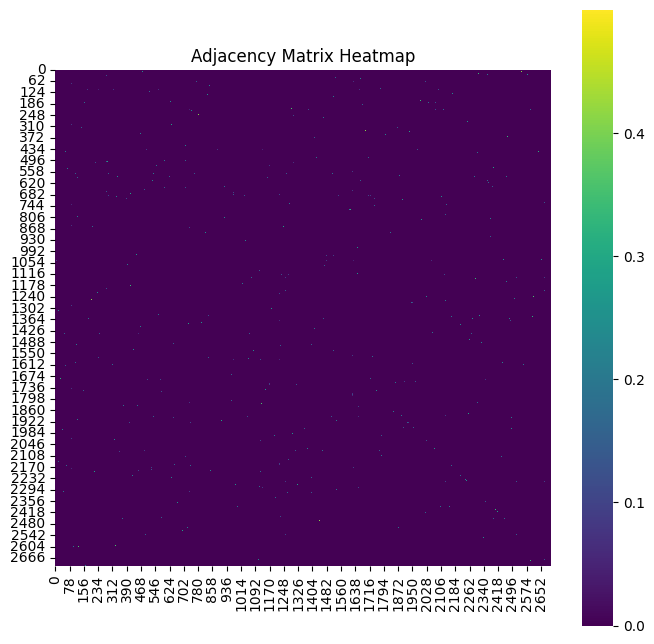

In [5]:
# adjacency matrices for Cora
A = to_dense_adj(data.edge_index, max_num_nodes = data.x.shape[0])[0]
A_tilde = A + torch.eye(A.shape[0])
D_tilde = torch.diag(torch.sum(A_tilde, axis=1))
D_tilde_inv_sqrt = torch.pow(D_tilde, -0.5)
D_tilde_inv_sqrt[torch.isinf(D_tilde_inv_sqrt)] = 0.0
A_tilde = A_tilde.to_sparse()
D_tilde_inv_sqrt = D_tilde_inv_sqrt.to_sparse()
adj_norm = torch.sparse.mm(torch.sparse.mm(D_tilde_inv_sqrt, A_tilde), D_tilde_inv_sqrt) # degree-normalised adjacency
L = torch.eye(adj_norm.shape[0]) - adj_norm  # graph laplacian

# # Eigenvectors with numpy
# EigVal, EigVec = np.linalg.eig(L)
# idx = EigVal.argsort() # sort in increasing order
# EigVal, EigVec = EigVal[idx], np.real(EigVec[:,idx])

plt.figure(figsize=(8, 8))
sns.heatmap(adj_norm.to_dense().numpy(), cmap='viridis', square=True)
plt.title('Adjacency Matrix Heatmap')
plt.show()

In [6]:
# PyG example code: https://github.com/pyg-team/pytorch_geometric/blob/master/examples/gcn2_cora.py

class GNNModel(Module):

    def __init__(
            self,
            in_dim: int = dataset.num_features,
            hidden_dim: int = 128,
            num_heads: int = 1,
            num_layers: int = 3,
            out_dim: int = dataset.num_classes,
            dropout: float = 0.5,
        ):
        super().__init__()

        self.lin_in = Linear(in_dim, hidden_dim)
        self.lin_out = Linear(hidden_dim, out_dim)

        self.layers = ModuleList()
        for layer in range(num_layers):
            self.layers.append(
                # GCNConv(hidden_dim, hidden_dim)
                GATConv(hidden_dim, hidden_dim // num_heads, num_heads)
            )
        self.dropout = dropout

    def forward(self, x, edge_index):

        x = self.lin_in(x)

        for layer in self.layers:
            # conv -> activation ->  dropout -> residual
            x_in = x
            x = layer(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, self.dropout, training=self.training)
            x = x_in + x

        x = self.lin_out(x)

        return x.log_softmax(dim=-1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GNNModel().to(device)

data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred, accs = model(data.x, data.edge_index).argmax(dim=-1), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        accs.append(int((pred[mask] == data.y[mask]).sum()) / int(mask.sum()))
    return accs


best_val_acc = test_acc = 0
times = []
for epoch in range(1, 100):
    start = time.time()
    loss = train()
    train_acc, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    print(f'Epoch: {epoch:04d}, Loss: {loss:.4f} Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}, Test: {tmp_test_acc:.4f}, '
          f'Final Test: {test_acc:.4f}')
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

Epoch: 0001, Loss: 1.9564 Train: 0.4143, Val: 0.1540, Test: 0.1650, Final Test: 0.1650
Epoch: 0002, Loss: 1.8827 Train: 0.7071, Val: 0.2200, Test: 0.2460, Final Test: 0.2460
Epoch: 0003, Loss: 1.8154 Train: 0.8929, Val: 0.2880, Test: 0.3280, Final Test: 0.3280
Epoch: 0004, Loss: 1.7430 Train: 0.9214, Val: 0.3480, Test: 0.4090, Final Test: 0.4090
Epoch: 0005, Loss: 1.6689 Train: 0.9571, Val: 0.4020, Test: 0.4590, Final Test: 0.4590
Epoch: 0006, Loss: 1.5866 Train: 0.9857, Val: 0.4600, Test: 0.4970, Final Test: 0.4970
Epoch: 0007, Loss: 1.5064 Train: 0.9929, Val: 0.4960, Test: 0.5360, Final Test: 0.5360
Epoch: 0008, Loss: 1.4049 Train: 0.9929, Val: 0.5420, Test: 0.5630, Final Test: 0.5630
Epoch: 0009, Loss: 1.3038 Train: 0.9929, Val: 0.5700, Test: 0.5910, Final Test: 0.5910
Epoch: 0010, Loss: 1.2217 Train: 0.9929, Val: 0.6120, Test: 0.6130, Final Test: 0.6130
Epoch: 0011, Loss: 1.0937 Train: 0.9929, Val: 0.6320, Test: 0.6360, Final Test: 0.6360
Epoch: 0012, Loss: 0.9883 Train: 0.9929, Va

In [11]:
ATTENTION_LIST = []
class SparseGraphTransformerModel(Module):

    def __init__(
            self,
            in_dim: int = dataset.num_features,
            hidden_dim: int = 128,
            num_heads: int = 1,
            num_layers: int = 3,
            out_dim: int = dataset.num_classes,
            dropout: float = 0.5,
        ):
        super().__init__()

        self.lin_in = Linear(in_dim, hidden_dim)
        self.lin_out = Linear(hidden_dim, out_dim)

        self.layers = ModuleList()
        for layer in range(num_layers):
            self.layers.append(
                # TransformerEncoderLayer(
                #     d_model = hidden_dim,
                #     nhead = num_heads,
                #     dim_feedforward = hidden_dim * 2,
                #     dropout = dropout,
                # )
                MultiheadAttention(
                    embed_dim = hidden_dim,
                    num_heads = num_heads,
                    dropout = dropout
                )
            )
        # self.encoder = TransformerEncoder(
        #     TransformerEncoderLayer(
        #         d_model = hidden_dim,
        #         nhead = num_heads,
        #         dim_feedforward = hidden_dim * 2,
        #         dropout = dropout,
        #     ),
        #     num_layers
        # )

        self.dropout = dropout

    def forward(self, x, dense_adj):

        x = self.lin_in(x)

        # TransformerEncoder
        # x = self.encoder(x, mask = ~dense_adj.bool())


        for layer in self.layers:
            # # TransformerEncoderLayer
            # # boolean mask enforces graph structure
            # x = layer(x, src_mask = ~dense_adj.bool())

            # MHSA layer
            # boolean mask enforces graph structure
            x_in = x
            x, attn_weights = layer(
                x, x, x,
                attn_mask = ~dense_adj.bool(),
                average_attn_weights = False
            )
            x = F.relu(x)
            x = F.dropout(x, self.dropout, training=self.training)
            x = x_in + x
            if epoch == 99:
              ATTENTION_LIST.append(attn_weights)
        x = self.lin_out(x)
        return x.log_softmax(dim=-1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SparseGraphTransformerModel().to(device)

data.dense_adj = to_dense_adj(data.edge_index, max_num_nodes = data.x.shape[0])[0]
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.dense_adj)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred, accs = model(data.x, data.dense_adj).argmax(dim=-1), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        accs.append(int((pred[mask] == data.y[mask]).sum()) / int(mask.sum()))
    return accs


best_val_acc = test_acc = 0
times = []
for epoch in range(1, 100):
    start = time.time()
    loss = train()
    train_acc, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    print(f'Epoch: {epoch:04d}, Loss: {loss:.4f} Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}, Test: {tmp_test_acc:.4f}, '
          f'Final Test: {test_acc:.4f}')
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

Epoch: 0001, Loss: 1.9455 Train: 0.4071, Val: 0.1700, Test: 0.1700, Final Test: 0.1700
Epoch: 0002, Loss: 1.8863 Train: 0.7786, Val: 0.2460, Test: 0.2360, Final Test: 0.2360
Epoch: 0003, Loss: 1.8281 Train: 0.9500, Val: 0.3100, Test: 0.3310, Final Test: 0.3310
Epoch: 0004, Loss: 1.7691 Train: 0.9786, Val: 0.4040, Test: 0.4160, Final Test: 0.4160
Epoch: 0005, Loss: 1.7044 Train: 0.9857, Val: 0.4600, Test: 0.4870, Final Test: 0.4870
Epoch: 0006, Loss: 1.6397 Train: 0.9857, Val: 0.5060, Test: 0.5440, Final Test: 0.5440
Epoch: 0007, Loss: 1.5733 Train: 1.0000, Val: 0.5720, Test: 0.5900, Final Test: 0.5900
Epoch: 0008, Loss: 1.4883 Train: 1.0000, Val: 0.6000, Test: 0.6380, Final Test: 0.6380
Epoch: 0009, Loss: 1.4136 Train: 1.0000, Val: 0.6340, Test: 0.6750, Final Test: 0.6750
Epoch: 0010, Loss: 1.3257 Train: 1.0000, Val: 0.6640, Test: 0.7000, Final Test: 0.7000
Epoch: 0011, Loss: 1.2481 Train: 1.0000, Val: 0.6900, Test: 0.7220, Final Test: 0.7220
Epoch: 0012, Loss: 1.1285 Train: 1.0000, Va

In [104]:
ATTENTION_MATRIX = ATTENTION_LIST[0].detach().cpu().numpy().squeeze()
ADJACENCY = data.dense_adj.cpu().numpy()
ATTENTION_MATRIX.shape, ADJACENCY.shape

((2708, 2708), (2708, 2708))

In [100]:
ATTENTION_MATRIX.sum(axis=0), ATTENTION_MATRIX.sum(axis=1)

(array([1.207743 , 0.       , 2.6072464, ..., 0.       , 2.018168 ,
        1.4597691], dtype=float32),
 array([1.9999999, 1.429992 , 1.1478934, ..., 0.       , 2.       ,
        1.5186529], dtype=float32))

In [92]:
(ADJACENCY.sum(axis=0) != ADJACENCY.sum(axis=1)).sum()

0

In [74]:
# (ADJACENCY -ATTENTION_MATRIX).sum(axis=0).sum()
# plt.figure(figsize=(8, 8))
# sns.heatmap(ADJACENCY, cmap='viridis', square=True)
# plt.title('ADJACENCY')
# plt.show()

In [105]:
treshold = 0
ATTENTION_MATRIX[ ATTENTION_MATRIX > treshold] = 1
ATTENTION_MATRIX[ ATTENTION_MATRIX < treshold] = 0
ATTENTION_MATRIX.sum()

5245.0

In [102]:
treshold = 0.5
ATTENTION_MATRIX[ ATTENTION_MATRIX >= treshold] = 1
ATTENTION_MATRIX[ ATTENTION_MATRIX < treshold] = 0
ATTENTION_MATRIX.sum()

2021.0

In [106]:
pd.DataFrame(ATTENTION_MATRIX.sum(axis=1)).value_counts()

1.0     899
2.0     625
0.0     511
3.0     337
4.0     169
5.0      63
6.0      33
7.0      17
9.0      14
8.0       8
10.0      7
11.0      6
15.0      4
12.0      2
14.0      2
18.0      2
13.0      1
17.0      1
19.0      1
21.0      1
23.0      1
33.0      1
35.0      1
44.0      1
98.0      1
dtype: int64

In [94]:
pd.DataFrame(ATTENTION_MATRIX.sum(axis=1))[pd.DataFrame(ATTENTION_MATRIX.sum(axis=1)) == 98.0].dropna()

,0
1358,98.0


In [95]:
ATTENTION_MATRIX[1358]

array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [97]:
ADJACENCY[1358].sum()

168.0

In [81]:
pd.DataFrame(ADJACENCY.sum(axis=0)).value_counts()

2.0      583
3.0      553
1.0      485
4.0      389
5.0      281
6.0      131
7.0       82
8.0       57
10.0      26
9.0       25
12.0      18
11.0      14
17.0       8
16.0       7
15.0       6
14.0       6
13.0       5
19.0       5
18.0       3
21.0       3
23.0       3
32.0       2
30.0       2
22.0       1
26.0       1
29.0       1
31.0       1
33.0       1
34.0       1
36.0       1
40.0       1
42.0       1
44.0       1
65.0       1
74.0       1
78.0       1
168.0      1
dtype: int64

In [ ]:
def get_shortest_path_matrix(adjacency_matrix):
    # Convert the adjacency matrix to a NetworkX graph
    graph = nx.from_numpy_array(adjacency_matrix.cpu().numpy(), create_using=nx.DiGraph)
    # Compute the shortest path matrix using Floyd-Warshall algorithm in NetworkX
    shortest_path_matrix = nx.floyd_warshall_numpy(graph)
    # Convert numpy array back to torch tensor
    shortest_path_matrix = torch.tensor(shortest_path_matrix).float()
    return shortest_path_matrix

In [47]:
pd.DataFrame(ATTENTION_MATRIX.sum(axis=0)).hist()

array([2., 0., 2., ..., 0., 3., 0.], dtype=float32)

In [46]:
ADJACENCY.sum(axis=0)

array([3., 3., 5., ..., 1., 4., 4.], dtype=float32)

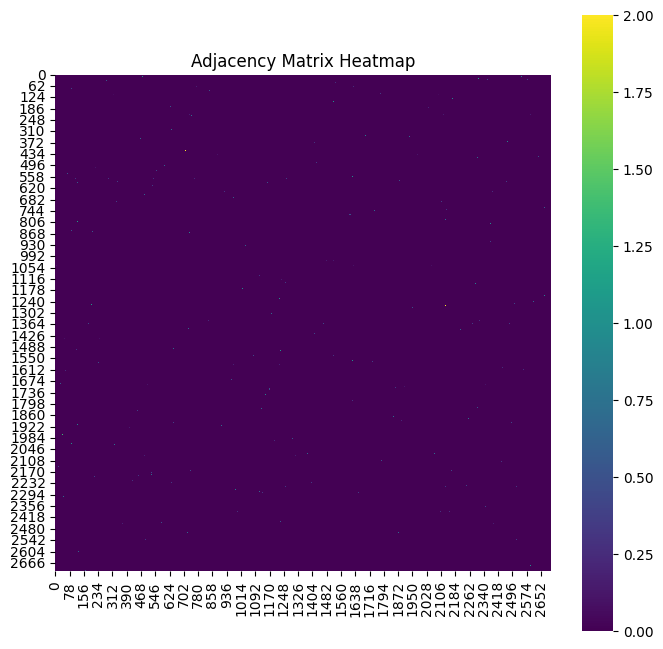

In [31]:
plt.figure(figsize=(8, 8))
sns.heatmap(ATTENTION_MATRIX, cmap='viridis', square=True)
plt.title('ATTENTION_MATRIX')
plt.show()

In [ ]:
num_layers = len(model.attn_weights_list)
num_heads = model.attn_weights_list[0].shape[0]

fig, axes = plt.subplots(num_layers, num_heads, figsize=(num_heads * 4, num_layers * 4))

for layer_idx in range(num_layers):
    for head_idx in range(num_heads):
        ax = axes[layer_idx, head_idx]

        # Extract the attention heatmap for the current layer and head
        attn_heatmap = model.attn_weights_list[layer_idx][head_idx, :, :].cpu().numpy()

        # Plot the heatmap on the current subplot
        sns.heatmap(attn_heatmap, cmap='viridis', square=True, ax=ax)

        ax.set_title(f'Layer {layer_idx + 1}, Head {head_idx + 1}')
        ax.axis('off')

plt.suptitle('Attention Heatmaps', y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
def get_shortest_path_matrix(adjacency_matrix):
    # Convert the adjacency matrix to a NetworkX graph
    graph = nx.from_numpy_array(adjacency_matrix.cpu().numpy(), create_using=nx.DiGraph)
    # Compute the shortest path matrix using Floyd-Warshall algorithm in NetworkX
    shortest_path_matrix = nx.floyd_warshall_numpy(graph)
    # Convert numpy array back to torch tensor
    shortest_path_matrix = torch.tensor(shortest_path_matrix).float()
    return shortest_path_matrix

dense_adj = to_dense_adj(data.edge_index, max_num_nodes = data.x.shape[0])[0]
dense_shortest_path_matrix = get_shortest_path_matrix(dense_adj)  # takes about 1-2 mins

In [ ]:
class DenseGraphTransformerModel(Module):

    def __init__(
            self,
            in_dim: int = dataset.num_features,
            pos_enc_dim: int = 16,
            hidden_dim: int = 128,
            num_heads: int = 4,
            num_layers: int = 3,
            out_dim: int = dataset.num_classes,
            dropout: float = 0.5,
        ):
        super().__init__()

        self.lin_in = Linear(in_dim, hidden_dim)
        self.lin_pos_enc = Linear(pos_enc_dim, hidden_dim)
        self.lin_out = Linear(hidden_dim, out_dim)

        self.layers = ModuleList()
        for layer in range(num_layers):
            self.layers.append(
                # TransformerEncoderLayer(
                #     d_model = hidden_dim,
                #     nhead = num_heads,
                #     dim_feedforward = hidden_dim * 2,
                #     dropout = dropout,
                # )
                MultiheadAttention(
                    embed_dim = hidden_dim,
                    num_heads = num_heads,
                    dropout = dropout
                )
            )
        # self.encoder = TransformerEncoder(
        #     TransformerEncoderLayer(
        #         d_model = hidden_dim,
        #         nhead = num_heads,
        #         dim_feedforward = hidden_dim * 2,
        #         dropout = dropout,
        #     ),
        #     num_layers
        # )

        self.attn_bias_scale = torch.nn.Parameter(torch.tensor([10.0]))  # controls how much we initially bias our model to nearby nodes
        self.dropout = dropout

    def forward(self, x, pos_enc, dense_sp_matrix):

        # x = self.lin_in(x) + self.lin_pos_enc(pos_enc)
        x = self.lin_in(x)  # no node positional encoding

        # attention bias
        # [i, j] -> inverse of shortest path distance b/w node i and j
        # diagonals -> self connection, set to 0
        # disconnected nodes -> -1
        attn_bias = self.attn_bias_scale * torch.nan_to_num(
            (1 / (torch.nan_to_num(dense_sp_matrix, nan=-1, posinf=-1, neginf=-1))),
            nan=0, posinf=0, neginf=0
        )

        # TransformerEncoder
        # x = self.encoder(x, mask = attn_bias)

        self.attn_weights_list = []

        for layer in self.layers:
            # # TransformerEncoderLayer
            # # float mask adds learnable additive attention bias
            # x = layer(x, src_mask = attn_bias)

            # MHSA layer
            # float mask adds learnable additive attention bias
            x_in = x
            x, attn_weights = layer(
                x, x, x,
                attn_mask = attn_bias,
                average_attn_weights = False
            )
            x = F.relu(x)
            x = F.dropout(x, self.dropout, training=self.training)
            x = x_in + x

            self.attn_weights_list.append(attn_weights)

        x = self.lin_out(x)

        return x.log_softmax(dim=-1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = DenseGraphTransformerModel().to(device)

data = T.AddLaplacianEigenvectorPE(k = 16, attr_name = 'pos_enc')(data)
# data = T.AddRandomWalkPE(walk_length = 16, attr_name = 'pos_enc')(data)
data.dense_adj = to_dense_adj(data.edge_index, max_num_nodes = data.x.shape[0])[0]
data.dense_sp_matrix = dense_shortest_path_matrix.float()  # pre-computed in previous cell
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.pos_enc, data.dense_sp_matrix)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred, accs = model(data.x, data.pos_enc, data.dense_sp_matrix).argmax(dim=-1), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        accs.append(int((pred[mask] == data.y[mask]).sum()) / int(mask.sum()))
    return accs


best_val_acc = test_acc = 0
times = []
for epoch in range(1, 100):
    start = time.time()
    loss = train()
    train_acc, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    print(f'Epoch: {epoch:04d}, Loss: {loss:.4f} Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}, Test: {tmp_test_acc:.4f}, '
          f'Final Test: {test_acc:.4f}')
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

# Notes
# - Dense Transformer needs to be trained for a bit longer to reach low loss value
# - Node positional encodings are not particularly useful
# - Edge distance encodings are very useful
# - Since Cora is highly homophilic, it is important to bias the attention towards nearby nodes

In [ ]:
num_layers = len(model.attn_weights_list)
num_heads = model.attn_weights_list[0].shape[0]

fig, axes = plt.subplots(num_layers, num_heads, figsize=(num_heads * 4, num_layers * 4))

for layer_idx in range(num_layers):
    for head_idx in range(num_heads):
        ax = axes[layer_idx, head_idx]

        # Extract the attention heatmap for the current layer and head
        attn_heatmap = model.attn_weights_list[layer_idx].cpu().numpy()[head_idx]

        # Plot the heatmap on the current subplot
        sns.heatmap(attn_heatmap, cmap='viridis', square=True, ax=ax)

        ax.set_title(f'Layer {layer_idx + 1}, Head {head_idx + 1}')
        ax.axis('off')

plt.suptitle('Attention Heatmaps', y=1.02)
plt.tight_layout()
plt.show()


In [ ]:
class DenseGraphTransformerModel(Module):

    def __init__(
            self,
            in_dim: int = dataset.num_features,
            pos_enc_dim: int = 16,
            hidden_dim: int = 128,
            num_heads: int = 4,
            num_layers: int = 3,
            out_dim: int = dataset.num_classes,
            dropout: float = 0.5,
        ):
        super().__init__()

        self.lin_in = Linear(in_dim, hidden_dim)
        self.lin_pos_enc = Linear(pos_enc_dim, hidden_dim)
        self.lin_out = Linear(hidden_dim, out_dim)

        self.layers = ModuleList()
        for layer in range(num_layers):
            self.layers.append(
                # TransformerEncoderLayer(
                #     d_model = hidden_dim,
                #     nhead = num_heads,
                #     dim_feedforward = hidden_dim * 2,
                #     dropout = dropout,
                # )
                MultiheadAttention(
                    embed_dim = hidden_dim,
                    num_heads = num_heads,
                    dropout = dropout
                )
            )
        # self.encoder = TransformerEncoder(
        #     TransformerEncoderLayer(
        #         d_model = hidden_dim,
        #         nhead = num_heads,
        #         dim_feedforward = hidden_dim * 2,
        #         dropout = dropout,
        #     ),
        #     num_layers
        # )

        # controls how much we initially bias our model to nearby nodes
        self.attn_bias_scale = Linear(1, num_heads, bias=False)
        with torch.no_grad():
            self.attn_bias_scale.weight.data = torch.linspace(
                0, 10, steps=num_heads, requires_grad=True
            ).unsqueeze(-1)

        self.dropout = dropout

    def forward(self, x, pos_enc, dense_sp_matrix):

        # x = self.lin_in(x) + self.lin_pos_enc(pos_enc)
        x = self.lin_in(x)  # no node positional encoding

        # attention bias
        # [i, j] -> inverse of shortest path distance b/w node i and j
        # diagonals -> self connection, set to 0
        # disconnected nodes -> -1
        attn_bias = torch.nan_to_num(
            (1 / (torch.nan_to_num(dense_sp_matrix, nan=-1, posinf=-1, neginf=-1))),
            nan=0, posinf=0, neginf=0
        ).unsqueeze(-1)
        # learnable scaling factor
        attn_bias = self.attn_bias_scale(attn_bias).permute(2, 0, 1)

        # TransformerEncoder
        # x = self.encoder(x, mask = attn_bias)

        self.attn_weights_list = []

        for layer in self.layers:
            # # TransformerEncoderLayer
            # # float mask adds learnable additive attention bias
            # x = layer(x, src_mask = attn_bias)

            # MHSA layer
            # float mask adds learnable additive attention bias
            x_in = x
            x, attn_weights = layer(
                x, x, x,
                attn_mask = attn_bias,
                average_attn_weights = False
            )
            x = F.relu(x)
            x = F.dropout(x, self.dropout, training=self.training)
            x = x_in + x

            self.attn_weights_list.append(attn_weights)

        x = self.lin_out(x)

        return x.log_softmax(dim=-1)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = DenseGraphTransformerModel().to(device)

data = T.AddLaplacianEigenvectorPE(k = 16, attr_name = 'pos_enc')(data)
# data = T.AddRandomWalkPE(walk_length = 16, attr_name = 'pos_enc')(data)
data.dense_adj = to_dense_adj(data.edge_index, max_num_nodes = data.x.shape[0])[0]
data.dense_sp_matrix = dense_shortest_path_matrix.float()  # pre-computed in previous cell
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.pos_enc, data.dense_sp_matrix)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return float(loss)


@torch.no_grad()
def test():
    model.eval()
    pred, accs = model(data.x, data.pos_enc, data.dense_sp_matrix).argmax(dim=-1), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        accs.append(int((pred[mask] == data.y[mask]).sum()) / int(mask.sum()))
    return accs


best_val_acc = test_acc = 0
times = []
for epoch in range(1, 100):
    start = time.time()
    loss = train()
    train_acc, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    print(f'Epoch: {epoch:04d}, Loss: {loss:.4f} Train: {train_acc:.4f}, '
          f'Val: {val_acc:.4f}, Test: {tmp_test_acc:.4f}, '
          f'Final Test: {test_acc:.4f}')
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

# Notes
# - Dense Transformer needs to be trained for a bit longer to reach low loss value
# - Node positional encodings are not particularly useful
# - Edge distance encodings are very useful
# - Since Cora is highly homophilic, it is important to bias the attention towards nearby nodes